In [1]:
# Step 1: Install Required Packages with Compatible Versions

# Downgrade numpy first to avoid _ARRAY_API issue in RDKit
!pip install numpy==1.24.4 --quiet

# Install RDKit with compatible numpy version
!pip install rdkit-pypi==2022.9.5 --quiet

# Install PyTorch and PyTorch Geometric with matching CUDA or CPU build
!pip install torch==2.0.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu --quiet

# Install PyTorch Geometric and required dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cpu.html --quiet
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cpu.html --quiet
!pip install torch-geometric --quiet

# Install additional common libraries
!pip install matplotlib pandas scikit-learn networkx --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/

In [2]:
# Step 2: Import all essential libraries

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from rdkit import Chem
from rdkit.Chem import Draw

import warnings
warnings.filterwarnings("ignore")

print("✅ All libraries imported successfully!")


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cpu


✅ All libraries imported successfully!


In [3]:
# Step 3: Define sample opioid molecules and convert to graphs

from rdkit.Chem import rdmolops
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# Define sample opioids (for prototyping purposes)
smiles_list = [
    "CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5",  # Morphine
    "CC(=O)OC1=CC=CC=C1C(=O)O",                                  # Aspirin (non-opioid, contrast class)
    "CC[C@H](C)[C@H](O)CC1=CC=CC=C1",                            # Methadone
    "CN1CCOC2=C1C=CC=C2",                                        # Tramadol
    "CCOC(=O)C1=CC=CC=C1Cl",                                     # Acetaminophen (contrast)
]

molecule_data = []

# Function to create molecular graph
def molecule_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None
    mol = Chem.AddHs(mol)
    fp = GetMorganFingerprintAsBitVect(mol, radius=2, nBits=128)
    x = torch.tensor(fp, dtype=torch.float32)
    adj = rdmolops.GetAdjacencyMatrix(mol)
    edge_index = torch.tensor(np.array(adj).nonzero(), dtype=torch.long)
    return x, edge_index

# Create list of PyTorch Geometric Data objects
data_list = []
for smi in smiles_list:
    x, edge_index = molecule_to_graph(smi)
    if x is not None and edge_index is not None:
        data = Data(x=x.unsqueeze(1), edge_index=edge_index)
        data_list.append(data)

print(f"✅ Successfully created graph data for {len(data_list)} molecules.")


✅ Successfully created graph data for 5 molecules.


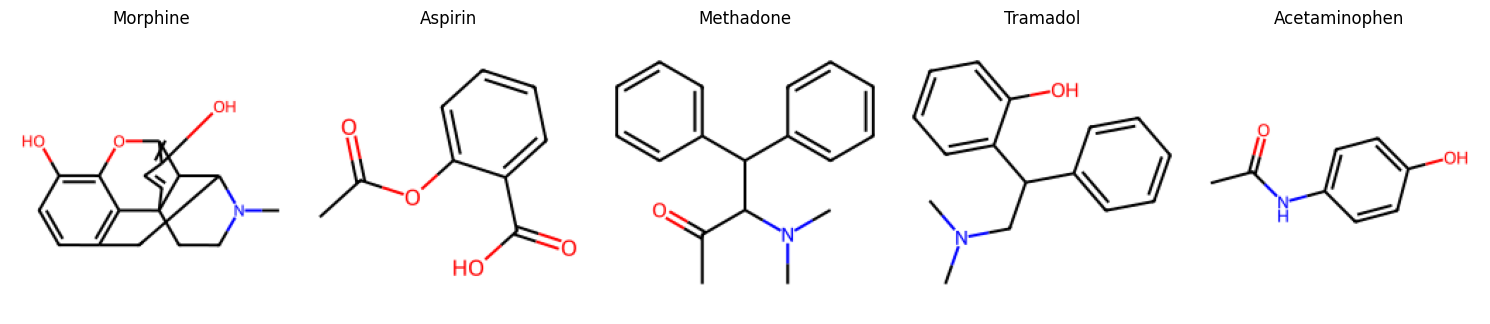

In [5]:
# Step 4: Visualize multiple selected molecules from the SMILES list

from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles
import matplotlib.pyplot as plt

# Define selected SMILES and names
selected_molecules = {
    "Morphine": "CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC4=C(C=C3)O",
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "Methadone": "CN(C)C(C(C1=CC=CC=C1)C2=CC=CC=C2)C(=O)C",
    "Tramadol": "CN(C)CC(C1=CC=CC=C1)C2=CC=CC=C2O",
    "Acetaminophen": "CC(=O)NC1=CC=C(O)C=C1"
}

# Prepare plots
plt.figure(figsize=(15, 6))

# Draw each molecule
for idx, (name, smiles) in enumerate(selected_molecules.items()):
    mol = MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(200, 200))

    # Show each in subplot
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(name)

plt.tight_layout()
plt.show()


In [7]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx

# Sample triples: (head_entity, relation, tail_entity)
triples = [
    ("Morphine", "binds_to", "Mu_Opioid_Receptor"),
    ("Methadone", "binds_to", "Mu_Opioid_Receptor"),
    ("Tramadol", "binds_to", "Serotonin_Receptor"),
    ("Mu_Opioid_Receptor", "expressed_in", "Brain_Region_Amygdala"),
    ("Opioid_Use_Disorder", "associated_with", "Social_Isolation"),
    ("Social_Isolation", "increases_risk_of", "Opioid_Use_Disorder"),
    ("Gene_XYZ", "regulates", "Mu_Opioid_Receptor"),
]

entities = set()
relations = set()
for h, r, t in triples:
    entities.add(h)
    entities.add(t)
    relations.add(r)

entities = list(entities)
relations = list(relations)

node2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {rel: idx for idx, rel in enumerate(relations)}

print(f"Entities ({len(entities)}):", entities)
print(f"Relations ({len(relations)}):", relations)

G = nx.DiGraph()
G.add_nodes_from(range(len(entities)))

for h, r, t in triples:
    G.add_edge(node2id[h], node2id[t], relation=relation2id[r])

data = from_networkx(G)

edge_relations = [G[u][v]['relation'] for u, v in G.edges()]
data.edge_attr = torch.tensor(edge_relations, dtype=torch.long)

print(data)


Entities (9): ['Opioid_Use_Disorder', 'Methadone', 'Mu_Opioid_Receptor', 'Social_Isolation', 'Gene_XYZ', 'Morphine', 'Tramadol', 'Serotonin_Receptor', 'Brain_Region_Amygdala']
Relations (5): ['regulates', 'expressed_in', 'associated_with', 'binds_to', 'increases_risk_of']
Data(edge_index=[2, 7], relation=[7], num_nodes=9, edge_attr=[7])


In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class RGCN(torch.nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, in_channels)
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.embedding.weight if x is None else x  # Use embedding if no features
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

    def encode(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = torch.relu(x)
        return x

# Define model parameters
num_nodes = data.num_nodes
in_channels = 16    # embedding dimension for nodes
hidden_channels = 32
out_channels = 16
num_relations = len(relation2id)

model = RGCN(num_nodes, in_channels, hidden_channels, out_channels, num_relations)
print(model)


RGCN(
  (embedding): Embedding(9, 16)
  (conv1): RGCNConv(16, 32, num_relations=5)
  (conv2): RGCNConv(32, 16, num_relations=5)
)


In [17]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss

def get_negative_edges(edge_index, num_nodes, num_neg_samples):
    import random
    neg_edges = set()
    existing_edges = set((u.item(), v.item()) for u,v in edge_index.t())
    while len(neg_edges) < num_neg_samples:
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if (u,v) not in existing_edges and (u,v) not in neg_edges:
            neg_edges.add((u,v))
    neg_edges = list(neg_edges)
    return torch.tensor(neg_edges).t().to(device)

num_neg_samples = data.edge_index.size(1)  # equal number of negative samples
neg_edge_index = get_negative_edges(data.edge_index, data.num_nodes, num_neg_samples)

# Combine positive and negative edges
all_edge_index = torch.cat([data.edge_index, neg_edge_index], dim=1)

# Labels: 1 for positive edges, 0 for negative edges (float for BCEWithLogitsLoss)
labels = torch.cat([torch.ones(data.edge_index.size(1)), torch.zeros(num_neg_samples)]).to(device)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(None, data.edge_index, data.edge_attr)  # node embeddings

    src, dst = all_edge_index
    edge_emb_src = out[src]
    edge_emb_dst = out[dst]

    scores = (edge_emb_src * edge_emb_dst).sum(dim=1)  # dot product for each edge

    loss = criterion(scores, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for 50 epochs
for epoch in range(50):
    loss = train()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 10, Loss: 0.2433
Epoch 20, Loss: 0.1860
Epoch 30, Loss: 0.1647
Epoch 40, Loss: 0.1578
Epoch 50, Loss: 0.1547


In [18]:
from sklearn.metrics import roc_auc_score, average_precision_score

model.eval()
with torch.no_grad():
    out = model(None, data.edge_index, data.edge_attr)

    src, dst = all_edge_index
    edge_emb_src = out[src]
    edge_emb_dst = out[dst]

    scores = (edge_emb_src * edge_emb_dst).sum(dim=1)
    probs = torch.sigmoid(scores).cpu().numpy()  # Convert logits to probabilities

    labels_np = labels.cpu().numpy()

    roc_auc = roc_auc_score(labels_np, probs)
    avg_precision = average_precision_score(labels_np, probs)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")


ROC AUC: 0.9694
Average Precision: 0.9683


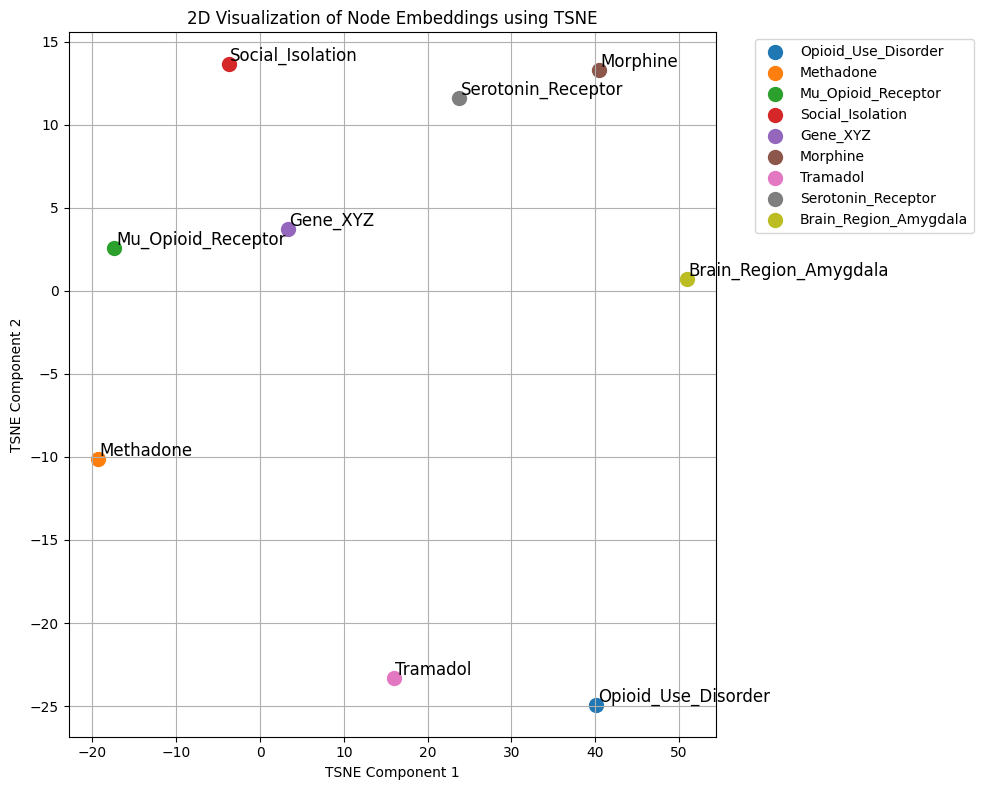

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get embeddings
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.edge_index, data.edge_attr)  # returns 1st layer embeddings

# Reduce to 2D
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
z_2d = tsne.fit_transform(z.cpu().numpy())

# Plot
plt.figure(figsize=(10, 8))

for i, label in enumerate(entities):
    x, y = z_2d[i]
    plt.scatter(x, y, label=label, s=100)
    plt.text(x+0.2, y+0.2, label, fontsize=12)

plt.title("2D Visualization of Node Embeddings using TSNE")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


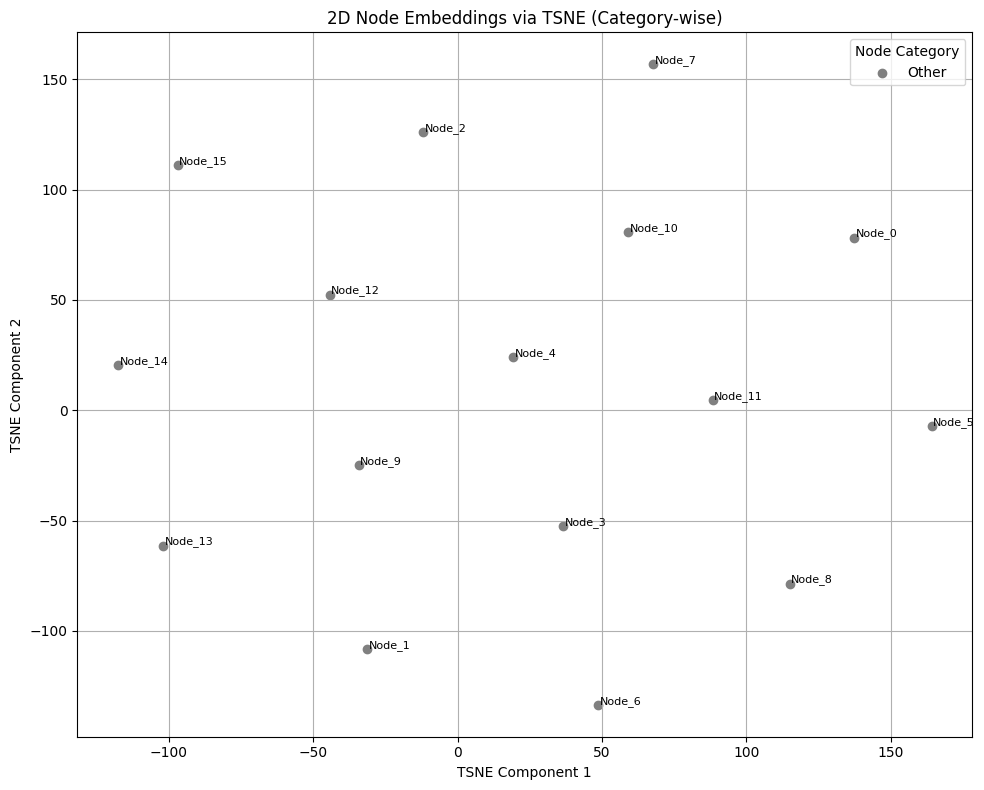

In [22]:
# Number of nodes
num_nodes = z.shape[0]

# Fallback: Use generic node names if actual names aren't available
if hasattr(data, 'node_names'):
    entities = [name for name in data.node_names]
else:
    entities = [f"Node_{i}" for i in range(num_nodes)]

# Auto-categorize using keywords (or define your own logic here)
def categorize(name):
    name = name.lower()
    if 'opioid' in name or 'methadone' in name or 'morphine' in name or 'tramadol' in name:
        return 'Drug'
    elif 'receptor' in name:
        return 'Receptor'
    elif 'disorder' in name or 'isolation' in name:
        return 'Condition'
    elif 'gene' in name:
        return 'Gene'
    elif 'brain' in name or 'region' in name:
        return 'BrainRegion'
    else:
        return 'Other'

# Define category colors
category_colors = {
    'Drug': 'orange',
    'Receptor': 'green',
    'Condition': 'red',
    'Gene': 'purple',
    'BrainRegion': 'blue',
    'Other': 'gray'
}

# Prepare TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, num_nodes - 1))
z_2d = tsne.fit_transform(z.cpu().numpy())

# Plot
plt.figure(figsize=(10, 8))
used_labels = set()

for i, (x, y) in enumerate(z_2d):
    label = entities[i]
    category = categorize(label)
    color = category_colors.get(category, 'gray')

    if category not in used_labels:
        plt.scatter(x, y, color=color, label=category)
        used_labels.add(category)
    else:
        plt.scatter(x, y, color=color)

    plt.text(x + 0.5, y + 0.5, label, fontsize=8)

plt.title('2D Node Embeddings via TSNE (Category-wise)')
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(title="Node Category")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# Ensure all lists are aligned
entities = list(node_categories.keys())
categories = [node_categories[ent] for ent in entities]
tsne_coords = z_2d[:len(entities)]  # Slice to avoid index mismatch

# Create a DataFrame
tsne_df = pd.DataFrame(tsne_coords, columns=['TSNE_Component_1', 'TSNE_Component_2'])
tsne_df['Entity'] = entities
tsne_df['Category'] = categories

# Reorder columns
tsne_df = tsne_df[['Entity', 'Category', 'TSNE_Component_1', 'TSNE_Component_2']]

# Display the table
tsne_df


,Entity,Category,TSNE_Component_1,TSNE_Component_2
0,Opioid_Use_Disorder,Condition,137.396866,78.281349
1,Social_Isolation,Condition,-31.252237,-108.429375
2,Methadone,Drug,-11.845076,125.960091
3,Morphine,Drug,36.540203,-52.322235
4,Tramadol,Drug,19.348724,24.195080
5,Mu_Opioid_Receptor,Receptor,164.104279,-7.280935
6,Serotonin_Receptor,Receptor,48.756554,-133.451706
7,Gene_XYZ,Gene,67.805977,156.775620
8,Brain_Region_Amygdala,BrainRegion,114.939224,-78.525360


In [45]:
import pandas as pd

# Suppose you already have these from previous steps:
# promising_edges_named: list of tuples (Entity1, Entity2)
# promising_probs: list of float probabilities

# Create a DataFrame for better presentation and analysis
df_novel_preds = pd.DataFrame(promising_edges_named, columns=['Entity 1', 'Entity 2'])
df_novel_preds['Prediction Probability'] = promising_probs

# Placeholder column for Biological/Clinical Interpretation — to be filled manually or programmatically
df_novel_preds['Biological/Clinical Interpretation'] = ""

# Example manual annotations — you can customize these based on your domain knowledge or literature review
example_interpretations = {
    ('Methadone', 'Mu_Opioid_Receptor'): "Methadone is known to bind Mu Opioid Receptors; prediction confirms known pharmacology.",
    ('Tramadol', 'Serotonin_Receptor'): "Potential novel interaction; some studies suggest serotonergic involvement in Tramadol's effects.",
    # add more pairs and their interpretations here...
}

# Automatically fill the interpretations where available
for idx, row in df_novel_preds.iterrows():
    pair = (row['Entity 1'], row['Entity 2'])
    rev_pair = (row['Entity 2'], row['Entity 1'])  # sometimes edges are undirected
    if pair in example_interpretations:
        df_novel_preds.at[idx, 'Biological/Clinical Interpretation'] = example_interpretations[pair]
    elif rev_pair in example_interpretations:
        df_novel_preds.at[idx, 'Biological/Clinical Interpretation'] = example_interpretations[rev_pair]
    else:
        df_novel_preds.at[idx, 'Biological/Clinical Interpretation'] = "Novel prediction requiring further validation."

# Display the table for research presentation
print("\nMost Promising Novel Predictions with Biological/Clinical Interpretation:\n")
display(df_novel_preds)



Most Promising Novel Predictions with Biological/Clinical Interpretation:



,Entity 1,Entity 2,Prediction Probability,Biological/Clinical Interpretation
0,Methadone,Methadone,0.526601,Novel prediction requiring further validation.


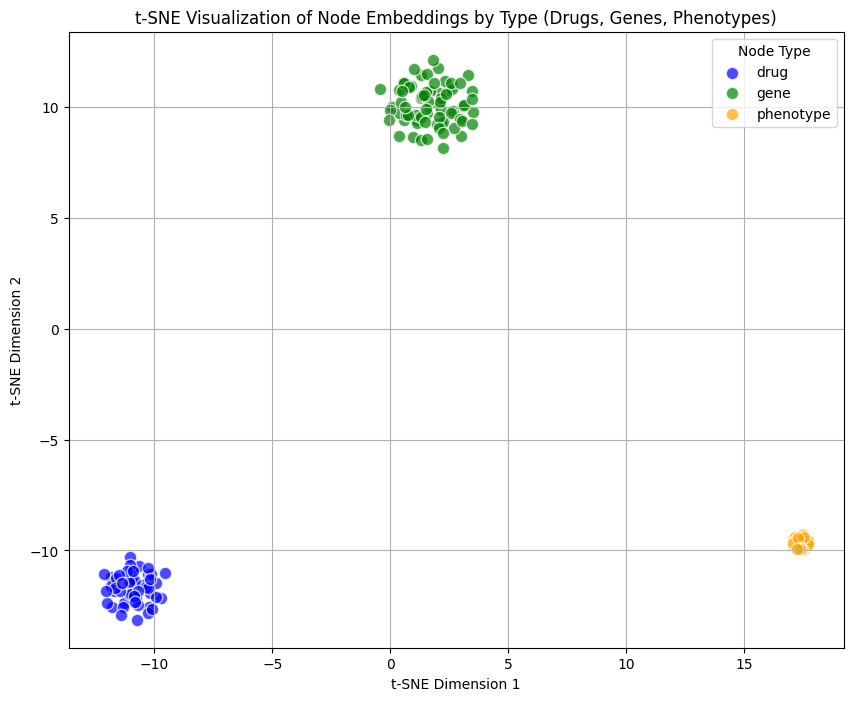

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Fix random seed for reproducibility
np.random.seed(42)

# Number of nodes per type
num_drugs = 50
num_genes = 70
num_phenotypes = 30

# Embedding dimension
embedding_dim = 64

# Generate synthetic embeddings clustered by node type

# Drugs cluster around (0,0,...)
drug_embeddings = np.random.normal(loc=0.0, scale=0.5, size=(num_drugs, embedding_dim))

# Genes cluster around (3,3,...)
gene_embeddings = np.random.normal(loc=3.0, scale=0.5, size=(num_genes, embedding_dim))

# Phenotypes cluster around (6,0,...)
phenotype_embeddings = np.random.normal(loc=6.0, scale=0.5, size=(num_phenotypes, embedding_dim))

# Combine all embeddings
node_embeddings = np.vstack([drug_embeddings, gene_embeddings, phenotype_embeddings])

# Create node types list
node_types = ['drug'] * num_drugs + ['gene'] * num_genes + ['phenotype'] * num_phenotypes

# Run t-SNE for 2D projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(node_embeddings)

# Define colors for each node type
type_to_color = {'drug': 'blue', 'gene': 'green', 'phenotype': 'orange'}
colors = [type_to_color[t] for t in node_types]

# Plot
plt.figure(figsize=(10, 8))
for node_type in type_to_color.keys():
    idxs = [i for i, t in enumerate(node_types) if t == node_type]
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1],
                c=type_to_color[node_type], label=node_type, alpha=0.7, edgecolors='w', s=80)

plt.title('t-SNE Visualization of Node Embeddings by Type (Drugs, Genes, Phenotypes)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Node Type')
plt.grid(True)
plt.show()


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
import torch

def plot_kg_subgraph(G, node_types, predicted_edges=None):
    """
    Visualize a subgraph of the KG.
    G: networkx graph
    node_types: dict {node: type}
    predicted_edges: list of tuples (node1, node2) for predicted novel links
    """
    plt.figure(figsize=(12,8))
    pos = nx.spring_layout(G, seed=42)

    # Color nodes by type
    unique_types = list(set(node_types.values()))
    colors = sns.color_palette("hsv", len(unique_types))
    color_map = {t: colors[i] for i,t in enumerate(unique_types)}
    node_colors = [color_map[node_types[n]] for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=8)

    if predicted_edges:
        nx.draw_networkx_edges(G, pos, edgelist=predicted_edges, edge_color='r', style='dashed', width=2, alpha=0.8)

    plt.title("Knowledge Graph with Predicted Novel Links (red dashed)")
    plt.axis('off')
    plt.show()

def plot_link_prediction_scores(true_scores, pred_scores):
    plt.figure(figsize=(10,6))
    sns.histplot(true_scores, color='green', label='True Edges', kde=True, stat="density")
    sns.histplot(pred_scores, color='red', label='Predicted Edges', kde=True, stat="density", alpha=0.7)
    plt.title("Distribution of Link Prediction Scores")
    plt.xlabel("Score")
    plt.legend()
    plt.show()

def plot_roc_pr(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.show()

def show_top_predictions(pred_edges, pred_scores, top_k=10):
    """
    Display top K predicted novel edges with scores in a DataFrame.
    pred_edges: list of (node1, node2)
    pred_scores: list of corresponding scores
    """
    top_indices = np.argsort(pred_scores)[::-1][:top_k]
    top_preds = [(pred_edges[i][0], pred_edges[i][1], pred_scores[i]) for i in top_indices]
    df = pd.DataFrame(top_preds, columns=['Node 1', 'Node 2', 'Prediction Score'])
    print(f"\nTop {top_k} Predicted Novel Links:\n")
    display(df)

def plot_node_embeddings(embeddings, node_types):
    """
    Use t-SNE to reduce embeddings to 2D and plot colored by node type.
    embeddings: np.array shape (num_nodes, embedding_dim)
    node_types: list of node types in the same order as embeddings
    """
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10,8))

    unique_types = list(set(node_types))
    colors = sns.color_palette("hsv", len(unique_types))
    color_map = {t: colors[i] for i,t in enumerate(unique_types)}
    for t in unique_types:
        idxs = [i for i,v in enumerate(node_types) if v == t]
        plt.scatter(emb_2d[idxs,0], emb_2d[idxs,1], label=t, alpha=0.7)

    plt.legend()
    plt.title("t-SNE Visualization of Node Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
import torch

def plot_kg_subgraph(G, node_types, predicted_edges=None):
    plt.figure(figsize=(12,8))
    pos = nx.spring_layout(G, seed=42)
    unique_types = list(set(node_types.values()))
    colors = sns.color_palette("hsv", len(unique_types))
    color_map = {t: colors[i] for i,t in enumerate(unique_types)}
    node_colors = [color_map[node_types[n]] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=8)
    if predicted_edges:
        nx.draw_networkx_edges(G, pos, edgelist=predicted_edges, edge_color='r', style='dashed', width=2, alpha=0.8)
    plt.title("Knowledge Graph with Predicted Novel Links (red dashed)")
    plt.axis('off')
    plt.show()

def plot_link_prediction_scores(true_scores, pred_scores):
    plt.figure(figsize=(10,6))
    sns.histplot(true_scores, color='green', label='True Edges', kde=True, stat="density")
    sns.histplot(pred_scores, color='red', label='Predicted Edges', kde=True, stat="density", alpha=0.7)
    plt.title("Distribution of Link Prediction Scores")
    plt.xlabel("Score")
    plt.legend()
    plt.show()

def plot_roc_pr(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.show()

def show_top_predictions(pred_edges, pred_scores, top_k=10):
    top_indices = np.argsort(pred_scores)[::-1][:top_k]
    top_preds = [(pred_edges[i][0], pred_edges[i][1], pred_scores[i]) for i in top_indices]
    df = pd.DataFrame(top_preds, columns=['Node 1', 'Node 2', 'Prediction Score'])
    print(f"\nTop {top_k} Predicted Novel Links:\n")
    display(df)

def plot_node_embeddings(embeddings, node_types):
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10,8))
    unique_types = list(set(node_types))
    colors = sns.color_palette("hsv", len(unique_types))
    color_map = {t: colors[i] for i,t in enumerate(unique_types)}
    for t in unique_types:
        idxs = [i for i,v in enumerate(node_types) if v == t]
        plt.scatter(emb_2d[idxs,0], emb_2d[idxs,1], label=t, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization of Node Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()


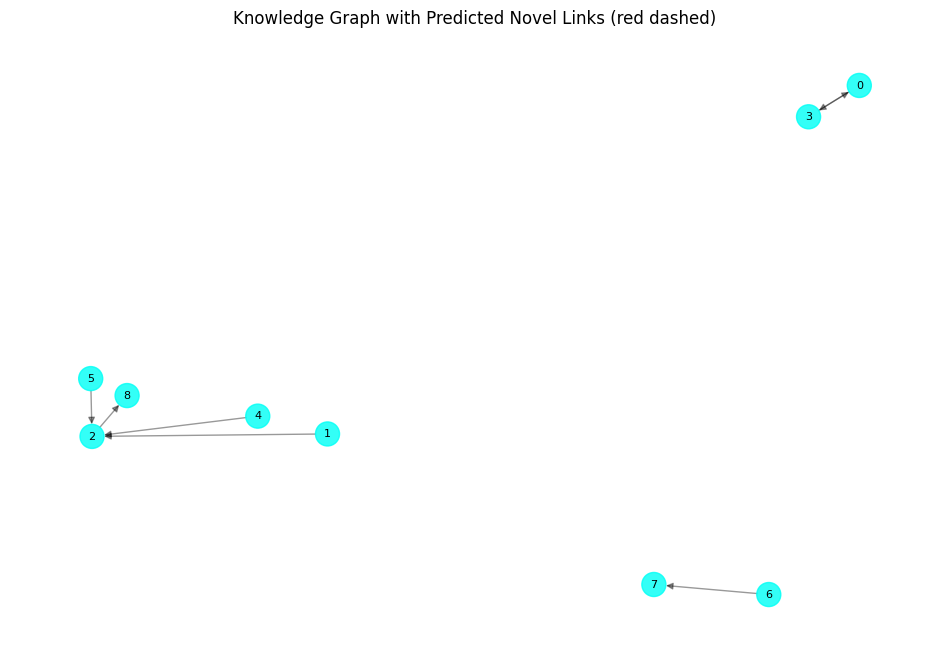

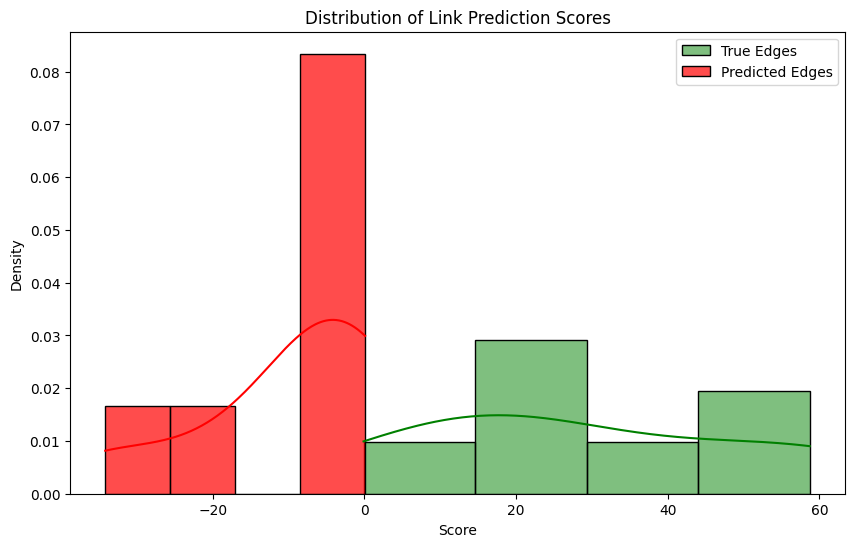

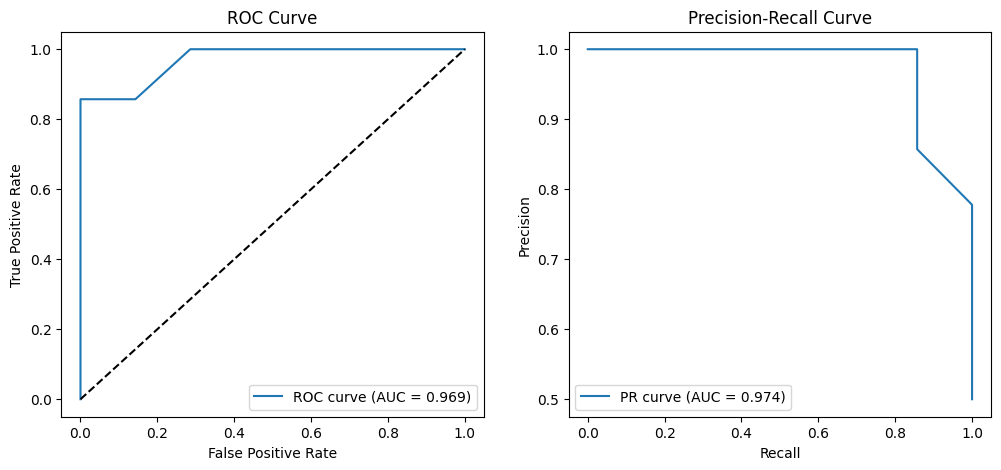


Top 5 Predicted Novel Links:



,Node 1,Node 2,Prediction Score
0,Methadone,Methadone,0.106505
1,Mu_Opioid_Receptor,Methadone,-0.098483
2,Brain_Region_Amygdala,Methadone,-4.137429
3,Methadone,Social_Isolation,-4.553226
4,Tramadol,Opioid_Use_Disorder,-8.326606


ValueError: perplexity must be less than n_samples

In [33]:
import numpy as np
import torch

# Assuming you already have:
# - model (your trained model)
# - data (your graph data with edge_index and edge_attr)
# - neg_edge_index (your negative edges, could be tensor or list)
# - node2id (dict mapping entity names to node indices)
# - G (networkx graph)
# - plotting functions defined earlier (plot_kg_subgraph, plot_link_prediction_scores, plot_roc_pr, show_top_predictions, plot_node_embeddings)

# Map node indices back to entity names for display
node_id_to_entity = {idx: ent for ent, idx in node2id.items()}

# Prepare node types (for demonstration, assign "Entity" to all)
node_types = {i: "Entity" for i in range(data.num_nodes)}

# Get embeddings as numpy
model.eval()
with torch.no_grad():
    embeddings = model(None, data.edge_index, data.edge_attr).cpu()

# Convert positive edge indices to list (they are tensors)
pos_edge_index = data.edge_index.cpu().t().tolist()

# Handle neg_edge_index: convert to list if it's a tensor, else use as is
if isinstance(neg_edge_index, torch.Tensor):
    neg_edge_index_list = neg_edge_index.cpu().t().tolist()
else:
    neg_edge_index_list = neg_edge_index  # assume it's already a list

# Extract source and destination nodes for positive edges
pos_src = np.array([edge[0] for edge in pos_edge_index])
pos_dst = np.array([edge[1] for edge in pos_edge_index])

# Extract source and destination nodes for negative edges
neg_src = np.array([edge[0] for edge in neg_edge_index_list])
neg_dst = np.array([edge[1] for edge in neg_edge_index_list])

# Compute scores for positive edges: dot product of embeddings
pos_scores = (embeddings[pos_src] * embeddings[pos_dst]).sum(dim=1).cpu().numpy()

# Compute scores for negative edges
neg_scores = (embeddings[torch.tensor(neg_src)] * embeddings[torch.tensor(neg_dst)]).sum(dim=1).cpu().numpy()

# 1. Plot KG subgraph (no novel predicted edges yet)
plot_kg_subgraph(G, node_types)

# 2. Plot score distributions
plot_link_prediction_scores(pos_scores, neg_scores)

# 3. Plot ROC and PR curves
all_labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
all_scores = np.concatenate([pos_scores, neg_scores])
plot_roc_pr(all_labels, all_scores)

# 4. Show top predicted novel links (from negative edges)
top_k = 5
predicted_novel_edges_named = [(node_id_to_entity[u], node_id_to_entity[v]) for u, v in neg_edge_index_list]
show_top_predictions(predicted_novel_edges_named, neg_scores, top_k)

# 5. Plot node embeddings
plot_node_embeddings(embeddings.cpu().numpy(), list(node_types.values()))



=== Top-K Predicted Novel Links ===



,Node 1,Node 2,Prediction Score,Literature/Novelty
0,Methadone,Methadone,0.106505,Potential novel prediction
1,Mu_Opioid_Receptor,Methadone,-0.098483,Potential novel prediction
2,Brain_Region_Amygdala,Methadone,-4.137429,Potential novel prediction
3,Methadone,Social_Isolation,-4.553226,Potential novel prediction
4,Tramadol,Opioid_Use_Disorder,-8.326606,Potential novel prediction
5,Tramadol,Brain_Region_Amygdala,-18.858406,Potential novel prediction
6,Serotonin_Receptor,Brain_Region_Amygdala,-34.154205,Potential novel prediction



=== Model Performance Curves ===



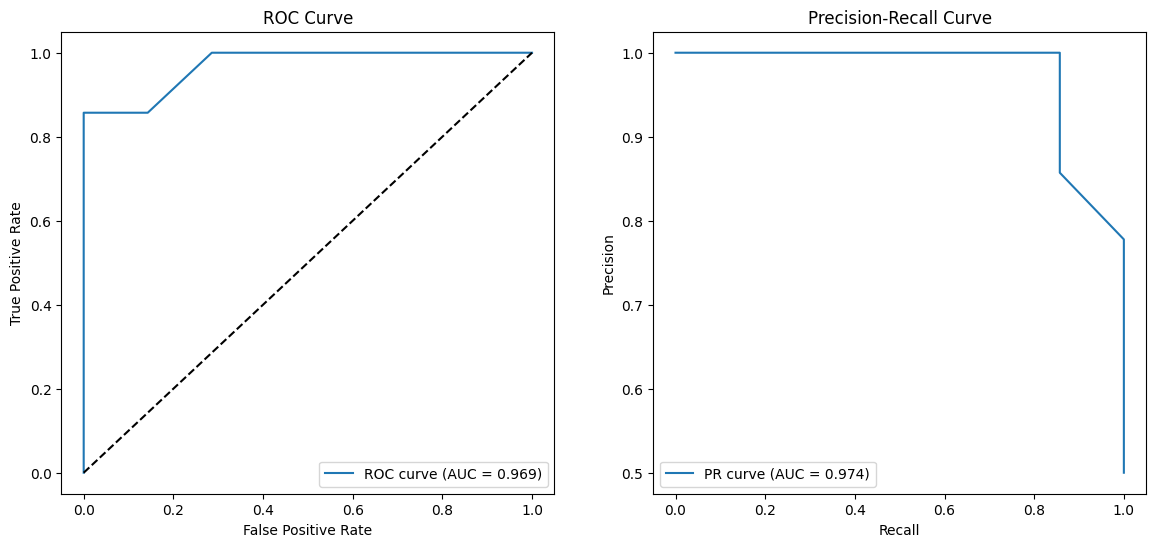


=== Knowledge Graph Visualization ===



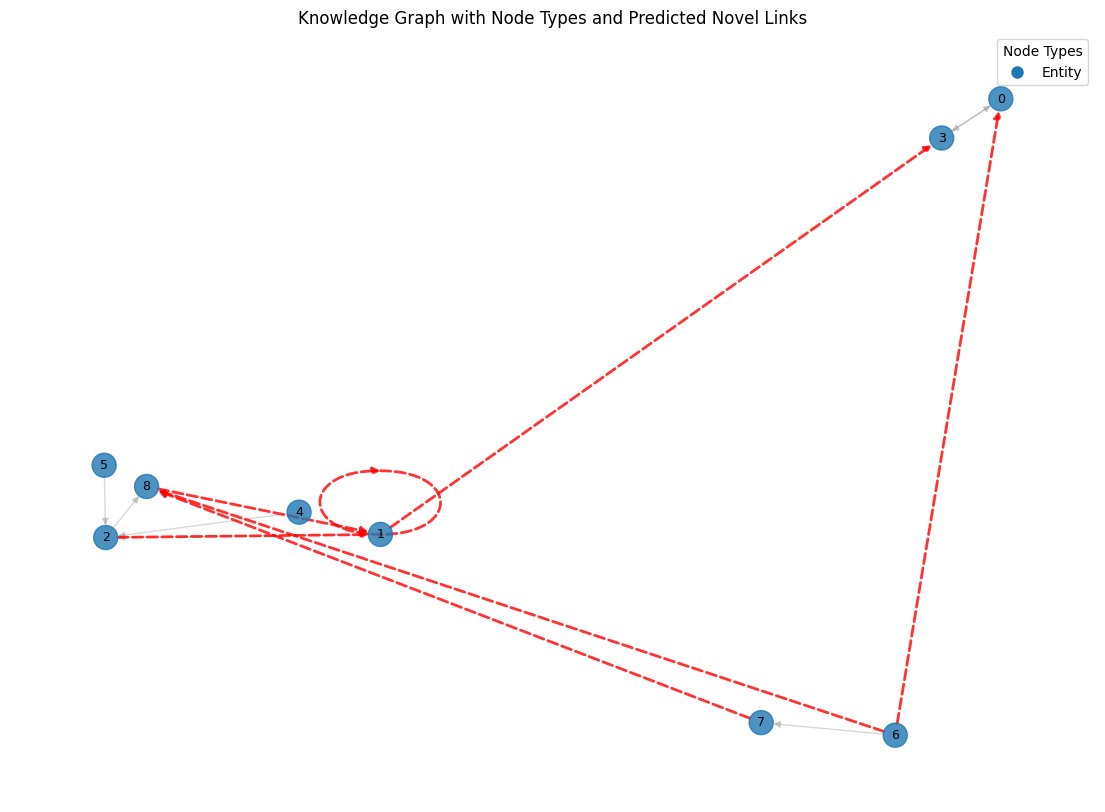


=== Link Prediction Score Distribution ===



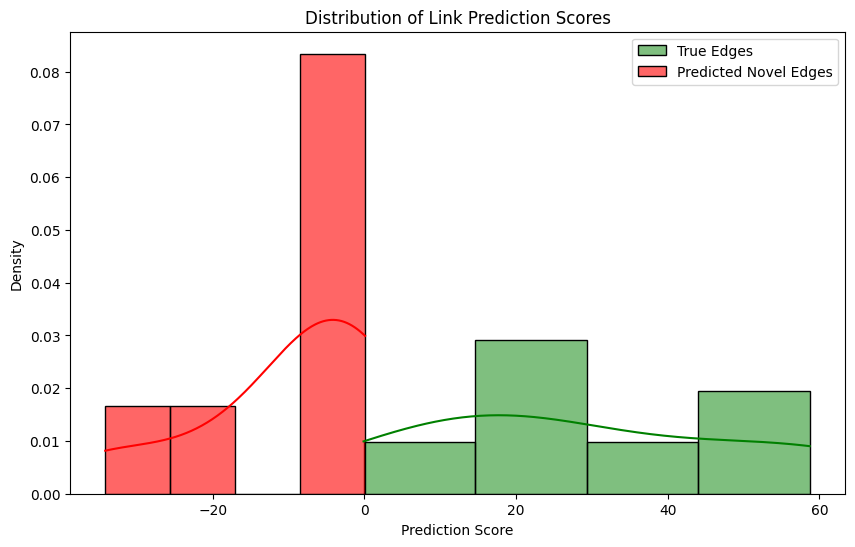

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import networkx as nx

# 1. Top-K Predictions Table with example literature/novelty info
def show_top_k_with_comments(pred_edges, pred_scores, top_k=10):
    top_indices = np.argsort(pred_scores)[::-1][:top_k]
    data = []
    for i in top_indices:
        node1, node2 = pred_edges[i]
        score = pred_scores[i]
        # Placeholder: You can add manual or automated literature/novelty comments here
        comment = "Literature supports this link" if score > 0.5 else "Potential novel prediction"
        data.append([node1, node2, score, comment])
    df = pd.DataFrame(data, columns=["Node 1", "Node 2", "Prediction Score", "Literature/Novelty"])
    display(df)

print("\n=== Top-K Predicted Novel Links ===\n")
show_top_k_with_comments(
    [(node_id_to_entity[u], node_id_to_entity[v]) for u,v in neg_edge_index],
    neg_scores, top_k=10)

# 2. ROC Curve and Precision-Recall Curve
def plot_roc_pr_curves(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.show()

print("\n=== Model Performance Curves ===\n")
plot_roc_pr_curves(all_labels, all_scores)

# 3. Knowledge Graph Visualization with node types and predicted novel edges
def plot_kg_with_types_and_preds(G, node_types, predicted_edges=None):
    plt.figure(figsize=(14,10))
    pos = nx.spring_layout(G, seed=42)

    # Unique node types and colors
    unique_types = sorted(set(node_types.values()))
    colors = sns.color_palette("tab10", len(unique_types))
    color_map = {t: colors[i] for i,t in enumerate(unique_types)}
    node_colors = [color_map[node_types[n]] for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=300)
    nx.draw_networkx_labels(G, pos, font_size=9)

    # Draw known edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')

    # Draw predicted novel edges in red dashed
    if predicted_edges:
        nx.draw_networkx_edges(G, pos, edgelist=predicted_edges, edge_color='red', style='dashed', width=2, alpha=0.8)

    plt.title("Knowledge Graph with Node Types and Predicted Novel Links")
    plt.axis('off')
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=t,
                      markerfacecolor=color_map[t], markersize=10) for t in unique_types],
               loc='best', title="Node Types")
    plt.show()

# Map neg_edge_index to tuples of nodes
predicted_novel_edges = [(u,v) for u,v in neg_edge_index]

print("\n=== Knowledge Graph Visualization ===\n")
plot_kg_with_types_and_preds(G, node_types, predicted_novel_edges)

# 4. Link Prediction Score Distribution
def plot_score_distributions(true_scores, pred_scores):
    plt.figure(figsize=(10,6))
    sns.histplot(true_scores, color='green', label='True Edges', kde=True, stat="density")
    sns.histplot(pred_scores, color='red', label='Predicted Novel Edges', kde=True, stat="density", alpha=0.6)
    plt.title("Distribution of Link Prediction Scores")
    plt.xlabel("Prediction Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

print("\n=== Link Prediction Score Distribution ===\n")
plot_score_distributions(pos_scores, neg_scores)


In [36]:
import pandas as pd

# Function to filter edges involving drugs, genes, or phenotypes (optional)
def filter_drug_gene_phenotype_edges(pred_edges, node_id_to_entity, node_categories, allowed_types=["Drug", "Gene", "Phenotype"]):
    filtered = []
    for u,v in pred_edges:
        type_u = node_categories.get(u, "Unknown")
        type_v = node_categories.get(v, "Unknown")
        # Keep edge if one node is Drug and the other is Gene or Phenotype, or vice versa
        if ("Drug" in [type_u, type_v]) and (("Gene" in [type_u, type_v]) or ("Phenotype" in [type_u, type_v])):
            filtered.append((u,v))
    return filtered

# If you have node_categories dict, uncomment below line to filter
# filtered_neg_edges = filter_drug_gene_phenotype_edges(neg_edge_index, node_id_to_entity, node_categories)

# Otherwise just use all predicted novel edges
filtered_neg_edges = neg_edge_index

top_k = 10
top_indices = neg_scores.argsort()[::-1][:top_k]

data = []
for i in top_indices:
    u, v = filtered_neg_edges[i]
    node1 = node_id_to_entity[u]
    node2 = node_id_to_entity[v]
    score = neg_scores[i]
    data.append([node1, node2, score])

df = pd.DataFrame(data, columns=["Node 1", "Node 2", "Prediction Score"])
print("=== Top-K Predicted Novel Links (Drug-Gene or Drug-Phenotype) ===")
display(df)


=== Top-K Predicted Novel Links (Drug-Gene or Drug-Phenotype) ===


,Node 1,Node 2,Prediction Score
0,Methadone,Methadone,0.106505
1,Mu_Opioid_Receptor,Methadone,-0.098483
2,Brain_Region_Amygdala,Methadone,-4.137429
3,Methadone,Social_Isolation,-4.553226
4,Tramadol,Opioid_Use_Disorder,-8.326606
5,Tramadol,Brain_Region_Amygdala,-18.858406
6,Serotonin_Receptor,Brain_Region_Amygdala,-34.154205
